**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# Initialize Jupyter Notebook. Scroll down for the report!

In [15]:
# Import libraries
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier # ovr
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import itertools
from sklearn import svm, datasets
import matplotlib


In [16]:
#Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
#Variables
scaler = StandardScaler()
ovr = None
output_file = "./output/normal_accuracy.csv"
output_file_logloss = "./output/normal_logloss.csv"
np.set_printoptions(precision=4)
labels = {1: 'Pop_Rock',
2: 'Electronic',
3: 'Rap',
4: 'Jazz',
5: 'Latin',
6: 'RnB',
7: 'International',
8: 'Country',
9: 'Reggae',
10: 'Blues'}
cm_lab = ['Pop_Rock',
'Electronic',
'Rap',
'Jazz',
'Latin',
'RnB',
'International',
'Country',
'Reggae',
'Blues']

In [18]:
def generate_train_labels():
    rhythm = ["rhythm%d" % i for i in range(0, 168)]
    chroma = ["chroma%d" % i for i in range(168, 216)]
    mfcc = ["mfcc%d" % i for i in range(216,264)]
    return rhythm + chroma + mfcc

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
# Writing logloss format
def write_output_logloss(model_prediction, output_file):
    with open(output_file, "w") as output:
        output.write("Sample_id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10\n")
        for idx, pred in enumerate(model_prediction):
            s= ""
            for val in pred:
                s += ", " + str(val)
            output.write(str(idx + 1) + s + "\n")
            

# Writing accuracy format
def write_output(model_prediction, output_file):
    with open(output_file, "w") as output:
        output.write("Sample_id,Sample_label\n")
        for idx, pred in enumerate(model_prediction):
            output.write(str(idx + 1) + "," + str(int(pred)) + "\n")

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_label_sample_and_histograms():
    display(HTML(train_data_labels_df[3456:3461].to_html(max_rows=5)))

    n, bins, patches = plt.hist(all_labels, 10, density=1, facecolor='g')
    plt.title('Histogram of Genres')
    plt.axis([1, 10, 0, 0.6])
    plt.xlabel("Genre")
    vals = plt.yticks()
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()

    n, bins, patches = plt.hist(all_labels[0:3000], 10, density=1, facecolor='g')
    plt.title("Histogram of first 3000 songs' Genres")
    plt.axis([1, 10, 0, 1])
    plt.xlabel("Genre")
    vals = plt.yticks()
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()

def print_feature_sample():
    display(HTML(train_data_df.to_html(max_rows=5)))

    
def test_optimal_pc_number():
    cov_mat = np.cov(all_train_features)
    u,s,v = np.linalg.svd(cov_mat)
    s_sum = np.sum(s)
    var = 1
    n_components = 240
    while n_components>80 and var>=0.9999:
        n_components -= 1
        var = float(np.sum(s[:n_components]))/s_sum
    n_components += 1
    print(n_components, " PC components give the optimal result")
    
def print_pca_reduced_feature_pairwise_plots(pc = 6):
    pca = PCA(n_components = pc, svd_solver = "full")
    features_for_scatter = pca.fit_transform(train_data_df)
    features_for_scatter = pd.DataFrame(features_for_scatter)
    features_for_scatter['labels'] = all_labels_text

    pp = sns.pairplot(features_for_scatter, size=1.8, aspect=1.8,
                      plot_kws=dict(edgecolor="k", linewidth=0.5),
                      diag_kind="kde", diag_kws=dict(shade=True), hue= 'labels')

    fig = pp.fig 
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle('PCA Components Pair-wise plot', fontsize=14)
    
    
def pca_lr(pc = 6, random_state = 23, solver = 'lbfgs', max_iter = 1000):
    # Trials with ML algorithms
    pca = PCA(n_components = pc, svd_solver = "full")
    features_train_pca = pca.fit_transform(features_train)
    features_test_pca = pca.fit_transform(features_test)

    clf = LogisticRegression(random_state=random_state, solver=solver, max_iter = max_iter)
    ovr = OneVsRestClassifier(clf)
    ovr.fit(features_train_pca,labels_train)


    score_train = ovr.score(features_train_pca, labels_train)
    score_test = ovr.score(features_test_pca, labels_test)
    print("PCA ({} components) and Logistic Regression".format(pc))
    print("Accuracy from training data is {:.4f} and from test data {:.4f}. The difference is {:.4f}".format(float(score_train), float(score_test), float(score_train-score_test)))

    test_data_df_pca = pca.fit_transform(test_data_df)
    predictData = ovr.predict(test_data_df_pca)
    predictProbData = ovr.predict_proba(test_data_df_pca)
    #y_pred = clf.predict(X_test)
    #accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    return ovr
    
def rfc(random_state = 23, n_estimators = 100, max_depth = 4):
    clf = RandomForestClassifier(random_state=random_state, n_estimators=n_estimators, max_depth=max_depth)
    ovr = OneVsRestClassifier(clf)
    ovr.fit(features_train,labels_train)


    score_train = ovr.score(features_train, labels_train)
    score_test = ovr.score(features_test, labels_test)
    print("Random Forest Classifier")
    print("Accuracy from training data is {:.4f} and from test data {:.4f}. The difference is {:.4f}".format(float(score_train), float(score_test), float(score_train-score_test)))


    predictData = ovr.predict(test_data_df)
    predictProbData = ovr.predict_proba(test_data_df)

    #y_pred = clf.predict(X_test)
    #accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    
    return ovr#, predictData, predictProbData

def lr_balanced(random_state = 42, solver = 'lbfgs', class_weight='balanced', max_iter = 1000):
    # With balanced. It creates a new data set
    clf = LogisticRegression(random_state=random_state, solver=solver, class_weight=class_weight, max_iter = max_iter)
    ovr = OneVsRestClassifier(clf)
    ovr.fit(features_train,labels_train)

    score_train = ovr.score(features_train, labels_train)
    score_test = ovr.score(features_test, labels_test)
    print("Logistic Regression with Balancing")
    print("Accuracy from training data is {:.4f} and from test data {:.4f}. The difference is {:.4f}".format(float(score_train), float(score_test), float(score_train-score_test)))

    predictData = ovr.predict(test_data_df)
    predictProbData = ovr.predict_proba(test_data_df)
    

    #y_pred = clf.predict(X_test)
    #accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    
    return ovr#, predictData, predictProbData
    
def lr(random_state = 42, solver = 'lbfgs', max_iter = 800):
    clf = LogisticRegression(random_state=random_state, solver=solver, max_iter = max_iter)
    ovr = OneVsRestClassifier(clf)
    ovr.fit(features_train,labels_train)

    score_train = ovr.score(features_train, labels_train)
    score_test = ovr.score(features_test, labels_test)
    print("Logistic Regression")
    print("Accuracy from training data is {:.4f} and from test data {:.4f}. The difference is {:.4f}".format(float(score_train), float(score_test), float(score_train-score_test)))

    predictData = ovr.predict(test_data_df)
    predictProbData = ovr.predict_proba(test_data_df)
    
    
    
    #y_pred = clf.predict(X_test)
    #accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    
    return ovr#, predictData, predictProbData
    
def print_confusion_matrix(model = "lr"):
    #Confusion matrix ...
    
    if model == "lr":
        ovr = lr()
    elif model == "lr_balanced":
        ovr = lr_balanced()
    elif model == "pca_lr":
        ovr = pca_lr()

    # Compute confusion matrix
    y_true = all_labels#labels_test
    y_pred = ovr.predict(all_train_features)#features_text
    class_names = [ '1', '2','3','4','5','6','7','8','9','10']
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                         title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.subplot(122)
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                         title='Normalized confusion matrix')

In [19]:
# Read in data
train_data_df = pd.read_csv("train_data.csv", header=None, names=generate_train_labels())
train_data_labels_df = pd.read_csv("train_labels.csv", header = None, names = ["Sample_label"])
test_data_df = pd.read_csv("test_data.csv", header = None)
test_data_df = test_data_df.as_matrix()
all_labels = train_data_labels_df.as_matrix()
all_labels_text = [labels[int(x)] for x in all_labels]
all_train_features = train_data_df.as_matrix()

# normalize data
scaler.fit(all_train_features)
test_data_df = scaler.transform(test_data_df)
all_train_features = scaler.transform(all_train_features)


# ##### REPORT STARTS ##### #

# *Song Genre Classification Using Logistic Regression and Random Forest Classifier*

## Abstract
The goal of this project was to create a predictor h(x) that predicts song genres using features from the songs by analyzing them with machine learning methods. This predictor needs to beat a dummy solution, which our solution did. The challenge was created with 10 different classes in an inbalanced dataset. We tried few different interesting methods. Best one proved to be Logistic regression without feature reduction. This method scored over the given dummy solution and performed descently even the data was highly imbalanced.

## 1. Introduction
In this project our goal is to classify songs by their genre. The classification is implemented by methods we have learned in the Machine Learning Basic Principle (MLBP) course so far. Classification of songs is a good real-life case where Machine Learning (ML) methods can be utilized while the topic is still easily understandable. For instance, song classification algorithm can be used by Spotify for song recommendations based on some user's most listened songs. 

Although the project is well defined and easily understood by human, it is however not a easy task for machines. Some of the genres are very distinct from each other, such as heavy metal and jazz. On the other hand, many features of pop and blues are very close to each other which makes the distinction between these genres a lot harder.

In a nutshell, the goal was to construct a predictor h(x) for each genre and analyse how well this predictor is.
The goal of this project is to apply the machine learning concepts we have learned so far in the class in a real life case which is determine genre of a song by over 200 features of the song. 

Our report consist of following chapters 2) Data analysis, 3) Methods and Experiments, 4) Results and finally 5) Discussion and Conclusion. In chapter 2 we have familiarized ourselves with the given training data and its multiple different features. The insights from data analysis stand a crucial part in choosing of method. The implementation and experiments of ML methods have been documented in chapter 3 following chapter 4 where results of experiments are presented. In the last chapter 5 we have discussed our learnings from the project.

## 2. Data analysis
For the project we have been provided feature data and label data for training of the model, and also test data without labels for validating of the accuracy and logloss on Kaggle. The label data includes label for each sample in feature dataset. There are in total 10 different labels (class) varying from electronic to jazz. A sample of the data is shown below.

The class distribution is rather skewed towards the Genre 1 which is Pop & Rock. Almost 60% of the songs are classified as 1 (Pop & Rock). The domination of one class can affect the classification which has to be taken into account when testing models. In the next chapter we have discussed a method where we tried to balance the data before training for better results.

Furthermore, the data is ordered in such a way that first 3000 of the samples are 80% class 1, see second histogram. This needs to be taken into account when splitting the data.

,Sample_label
3456,2
3457,10
3458,2
3459,7
3460,4


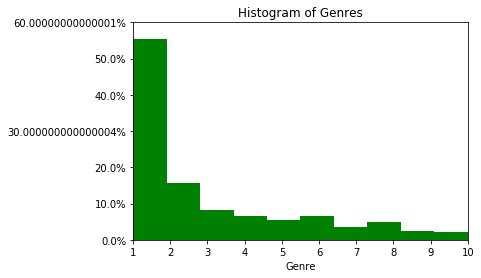

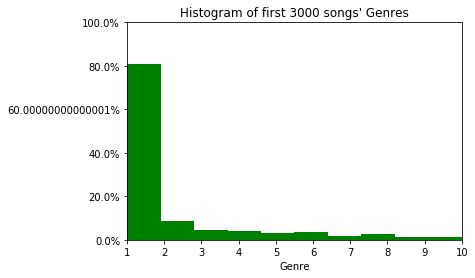

In [7]:
print_label_sample_and_histograms()

The feature data provided to us consists of 4364 samples of which each has 264 features. The features are divided in three categories: 1) Rhytm (168 features) 2) Pitch (48 features) and 3) Timbre (48 features). The dimensionality of the data is hence rather high. A sample of the data is shown below




In [20]:
print_feature_sample()

,rhythm0,rhythm1,rhythm2,rhythm3,rhythm4,rhythm5,rhythm6,rhythm7,rhythm8,rhythm9,rhythm10,rhythm11,rhythm12,rhythm13,rhythm14,rhythm15,rhythm16,rhythm17,rhythm18,rhythm19,rhythm20,rhythm21,rhythm22,rhythm23,rhythm24,rhythm25,rhythm26,rhythm27,rhythm28,rhythm29,rhythm30,rhythm31,rhythm32,rhythm33,rhythm34,rhythm35,rhythm36,rhythm37,rhythm38,rhythm39,rhythm40,rhythm41,rhythm42,rhythm43,rhythm44,rhythm45,rhythm46,rhythm47,rhythm48,rhythm49,rhythm50,rhythm51,rhythm52,rhythm53,rhythm54,rhythm55,rhythm56,rhythm57,rhythm58,rhythm59,rhythm60,rhythm61,rhythm62,rhythm63,rhythm64,rhythm65,rhythm66,rhythm67,rhythm68,rhythm69,rhythm70,rhythm71,rhythm72,rhythm73,rhythm74,rhythm75,rhythm76,rhythm77,rhythm78,rhythm79,rhythm80,rhythm81,rhythm82,rhythm83,rhythm84,rhythm85,rhythm86,rhythm87,rhythm88,rhythm89,rhythm90,rhythm91,rhythm92,rhythm93,rhythm94,rhythm95,rhythm96,rhythm97,rhythm98,rhythm99,rhythm100,rhythm101,rhythm102,rhythm103,rhythm104,rhythm105,rhythm106,rhythm107,rhythm108,rhythm109,rhythm110,rhythm111,rhythm112,rhythm113,rhythm114,rhythm115,rhythm116,rhythm117,rhythm118,rhythm119,rhythm120,rhythm121,rhythm122,rhythm123,rhythm124,rhythm125,rhythm126,rhythm127,rhythm128,rhythm129,rhythm130,rhythm131,rhythm132,rhythm133,rhythm134,rhythm135,rhythm136,rhythm137,rhythm138,rhythm139,rhythm140,rhythm141,rhythm142,rhythm143,rhythm144,rhythm145,rhythm146,rhythm147,rhythm148,rhythm149,rhythm150,rhythm151,rhythm152,rhythm153,rhythm154,rhythm155,rhythm156,rhythm157,rhythm158,rhythm159,rhythm160,rhythm161,rhythm162,rhythm163,rhythm164,rhythm165,rhythm166,rhythm167,chroma168,chroma169,chroma170,chroma171,chroma172,chroma173,chroma174,chroma175,chroma176,chroma177,chroma178,chroma179,chroma180,chroma181,chroma182,chroma183,chroma184,chroma185,chroma186,chroma187,chroma188,chroma189,chroma190,chroma191,chroma192,chroma193,chroma194,chroma195,chroma196,chroma197,chroma198,chroma199,chroma200,chroma201,chroma202,chroma203,chroma204,chroma205,chroma206,chroma207,chroma208,chroma209,chroma210,chroma211,chroma212,chroma213,chroma214,chroma215,mfcc216,mfcc217,mfcc218,mfcc219,mfcc220,mfcc221,mfcc222,mfcc223,mfcc224,mfcc225,mfcc226,mfcc227,mfcc228,mfcc229,mfcc230,mfcc231,mfcc232,mfcc233,mfcc234,mfcc235,mfcc236,mfcc237,mfcc238,mfcc239,mfcc240,mfcc241,mfcc242,mfcc243,mfcc244,mfcc245,mfcc246,mfcc247,mfcc248,mfcc249,mfcc250,mfcc251,mfcc252,mfcc253,mfcc254,mfcc255,mfcc256,mfcc257,mfcc258,mfcc259,mfcc260,mfcc261,mfcc262,mfcc263
0,1040.7,2315.6,2839.1,2552.2,2290.4,1913.8,2152.6,1930.3,2079.30,1706.70,1953.4,1513.5,1882.6,1802.7,2050.5,1891.1,1614.4,950.52,787.93,697.59,477.02,301.42,122.39,1.499,580.9,2149.8,1543.6,1046.4,1588.9,1388.50,1527.4,1135.00,1244.20,1088.60,1636.4,1044.8,1763.0,1476.8,1979.7,1503.20,1168.30,286.36,203.43,192.00,106.19,76.905,26.470,0.016,989.47,1484.40,744.62,367.04,961.96,1378.60,963.90,1206.20,926.070,1363.7,1262.30,1185.70,1566.60,1073.40,1383.60,1270.50,1197.40,857.27,1121.20,1373.70,1359.90,2052.600,2598.00,11504.0,3987.6,5632.8,3509.8,2556.8,4313.3,5500.1,3890.4,5192.5,3813.0,5921.8,4324.7,4601.6,7033.8,3856.0,5336.3,4940.8,4560.1,4190.1,5504.3,6080.7,5272.6,9246.9,12185.0,150390.0,831.58,1914.5,2639.0,2439.4,2064.3,1673.40,1931.50,1748.0,1846.50,1492.10,1566.50,1291.50,1552.60,1464.30,1697.6,1575.8,1344.2,863.88,726.28,590.76,393.19,217.53,66.00,1.066,6.04,203.38,430.020,500.560,217.930,303.610,209.620,214.750,291.370,198.770,202.13,169.680,210.850,165.780,231.080,258.480,176.540,21.119,73.797,80.082,37.997,24.555,1.593,1.066,4097.7,8669.9,7205.8,5314.4,7448.6,6748.8,6298.5,6559.9,6393.4,6705.8,6701.1,5542.9,8142.4,6256.2,7571.7,6894.4,5794.4,3102.8,2811.0,2781.5,1743.1,1705.5,1037.80,49.366,0.53113,0.27914,0.29100,0.18867,0.27142,0.43106,0.23045,0.30437,0.19682,0.36930,0.35071,0.22654,0.131870,0.054957,0.084974,0.037669,0.066023,0.125500,0.047220,0.094917,0.040921,0.110060,0.099065,0.045715,0.010,0.009,0.007,0.003,0.002,0.007,0.006,0.006,0.003,0.004,0.003,0.003,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1000000.0,1000000.

Analysing the data visually is very hard when the dimensionality increases over 3. There are multiple ways for reducing the dimensions of dataset, so it can be further analyzed. We have used PCA to reduce the number of features.
The features are divided in three categories: 1) Timbre; 2) Rhytm and 3) Pitch. In theory the data could be reduced to these three components, but if the features are reduced under, see below.

We noticed by trial and error that with six Principle Components it is possible to maintain accuracy of the data and 99% of the variance of the data.

In [8]:
#test_optimal_pc_number()

Below we have reduced the number of features from 264 down to 6, and plotted features in pairwise plot. From the plot it is obvious that there is correlation between some features. There are also quite a few features which create a T shaped plot in different directions which means that the correlation is not linear.

There are only two cases where points where points where no correlation can be seen between features, such as 2 vs 5. All points have also been colored by the label, and from the plots it can be seen that the colors are highly mixed and no distinct clusters can be seen. This may indicate that good results cannot be obtained from this dataset as it is not easy to distinct different labels by their features. 

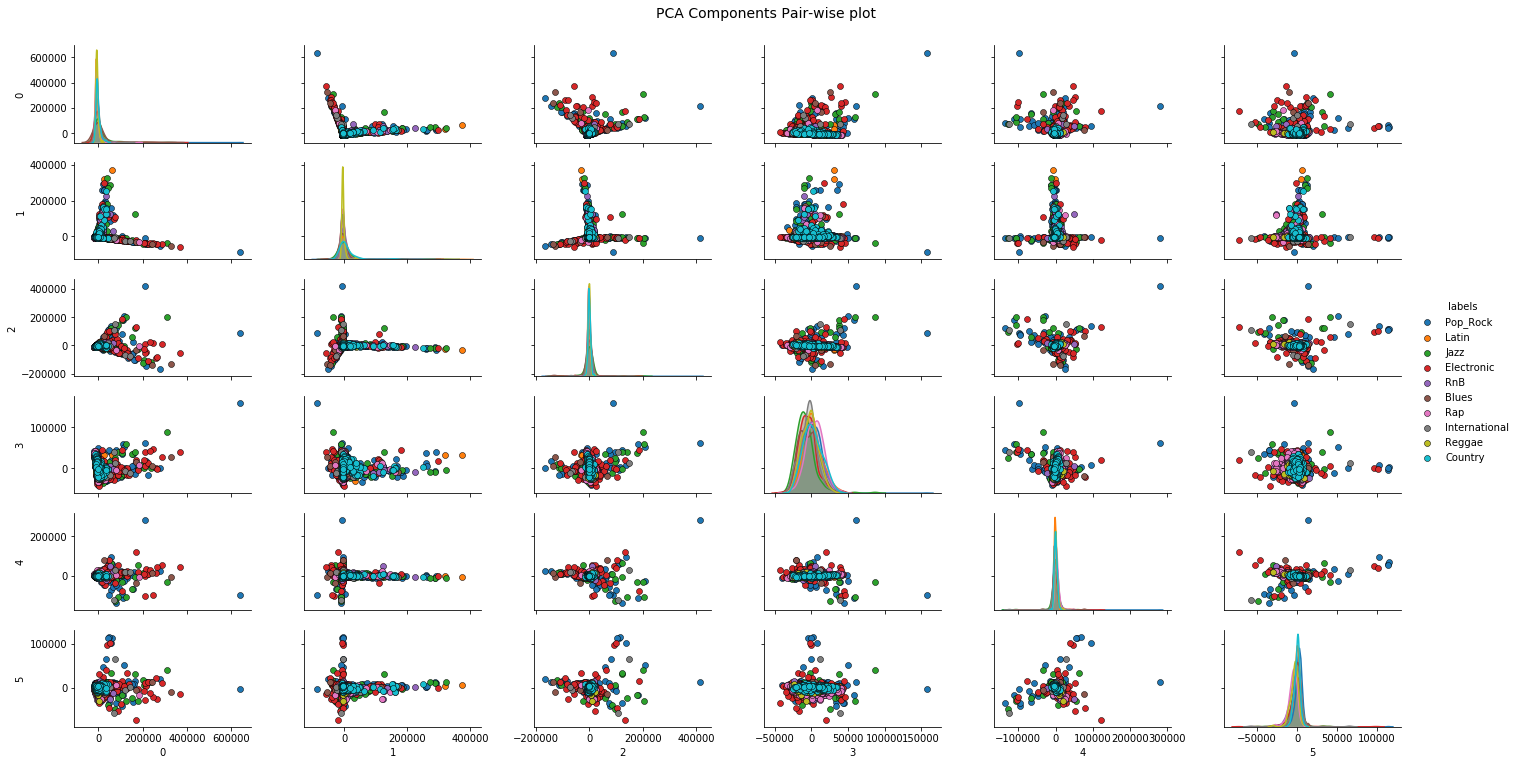

In [47]:
print_pca_reduced_feature_pairwise_plots(pc=6)

We divided the training set two distinct sets, one for training and second for validation of the model. We started with the rule of thumb 70/30 ratio which proved to give the best results[5]. The other ratios we tried were 50/50, 60/40 and 80/20. 

As mentioned before, 80% of the first 3000 samples are class 1. For this reason we have also shuffled the data when splitting it, so both sets would have same distribution.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    all_train_features, all_labels, test_size = 0.3, shuffle=True)

# Changing variable names
labels_train = y_train
features_train = x_train
labels_test = y_test
features_test = x_test

print("Original dataset has {} samples. New training set has {} and validation set {}".format(train_data_df.shape[0], features_train.shape[0], features_test.shape[0]))

Original dataset has 4363 samples. New training set has 3054 and validation set 1309


## 3. Methods and experiments
Our implementation includes methods such as Logistic Regression and Random Forest Classifier. In this real-life case, it is also important to analyse the data before implementing any of the aforementioned methods. We have normalized the data in each implementation. In addition, cross-validation is done for the test data. [5]

### Approach

Our initial approach for modeling the problem was to minimize the dimensionality of the data with PCA as we have discussed before. Then using Logistic regression and One Versus Rest (OvR) multiclassification[1]. We have chosen Logistic regression as it is good for classification problem, that is the result is binary.[5]

#### Flow of the implementations:
1) PCA and Logistic Regression: Normalization of the data --> PCA for feature reduction --> Multiclass Logistics Regression.[1][2][4]

2) Random Forest classifier: Normalization of the data --> Random Forest Classification[3]

3) Logistics Regression: Normalization of the data --> Logistics regression[2]


###  PCA and Logistic Regression

As our first try we decided to use the PCA for reducing the high number offeatures before running Logistic regression, as we have already have analysed the data after PCA with 6 principal components.We noticed with trial and error that 6 principal components still keeps the variance almost 100%. Below you can find the code for using PCA and LogisticRegression for learning a model.



Accuracy from the given method for training data was 0.56 and for validation data 0.41. These figures are rather low for Logistic regression analysis model which motivated us to research other methods.

In [55]:
 pca_lr(pc = 6, random_state = 0, solver = 'lbfgs', max_iter = 1000)


PCA (6 components) and Logistic Regression
Accuracy from training data is 0.5648 and from test data 0.4125. The difference is 0.1523


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

### Random Forest Classifier

We tried classifier called RandomForestClassifier as it is "The state-of-art" classifier at time being[6]. With RF we acquired better results compared to the PCA and LR. Accuracy was 0.69 for training data and 0.58 for validation data. The difference between the accuracies was 0.1 which implies that overfitting might be present. Overall, the accuracy is descent.



In [14]:
rfc(random_state = 31, n_estimators = 100, max_depth = 5)

Random Forest Classifier
Accuracy from training data is 0.7014 and from test data 0.5546. The difference is 0.1468


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=31, verbose=0, warm_start=False),
          n_jobs=None)

### Logistic Regression with Balancing

With the skewed class distribution still in mind, we decided as next step to try to work on it. The scipy logistic regression has a parameter for automatically balancing some unevenly distributed data (class_weight). The 'balanced' mode tries to balance the distribution by adding new samples inversely proportional to class frequencies in the original data (n_samples / (n_classes * np.bincount(y)).

Unfortunately, the balancing did not provide us results we were hoping for. Accuracy for training data was 0.72 and for validation data to 0.54. As we can see, the difference is huge and overfitting is therefore large.

In [15]:
lr_balanced(random_state = 42, solver = 'lbfgs', class_weight='balanced', max_iter = 800)

Logistic Regression with Balancing
Accuracy from training data is 0.7308 and from test data 0.5493. The difference is 0.1816


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=800,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

### Logistic Regression without balancing

As a last resort, we decided to run Logistic regression without PCA nor balancing. We had thought that some extra effort into preprocessing the data and using extra features, such as balancing, should give us better results. However, it seems that without any of these we got the best results for training and validation data, accuracy of 0.79 and 0.63 respectively. 

In [56]:
lr(random_state = 0, solver = 'lbfgs', max_iter = 800)

Logistic Regression
Accuracy from training data is 0.7983 and from test data 0.6264. The difference is 0.1719


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=800, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [ ]:
# Output the above regression
#write_output(predictData, output_file)
#write_output_logloss(predictProbData, output_file_logloss)

## 4. Results
The best result was provided with Logistic regression without balancing

### Best results with Logistic regression without balancing
Testing data (kaggle):
- Accuracy: 0.62913
- Logloss: 0.19991

Cross Validation :
- Accuracy: 0.6318
- Logloss: 0.36

In [26]:
ovr = lr()

Logistic Regression
Accuracy from training data is 0.7983 and from test data 0.6264. The difference is 0.1719


### Other results

#### PCA and Logistic Regression
Testing data (kaggle):
- Accuracy: 0.50
- Logloss: 0.24

Cross Validation :
- Accuracy: 0.4354
- Logloss: 0.23

In [18]:
ovr = pca_lr()

PCA (6 components) and Logistic Regression
Accuracy from training data is 0.5540 and from test data 0.4698. The difference is 0.0842


#### Random Forest Classifier
Testing data (kaggle):
- Accuracy: 0.56240
- Logloss: 0.20659

Cross Validation :
- Accuracy: 0.5668
- Logloss: 0.35

In [19]:
ovr = rfc()

Random Forest Classifier
Accuracy from training data is 0.6264 and from test data 0.5913. The difference is 0.0351


#### Logistic regression with Balancing
Testing data (kaggle):
- Accuracy: n/a
- Logloss: n/a

Cross Validation :
- Accuracy: 0.5416
- Logloss: 0.61

In [20]:
ovr = lr_balanced()

Logistic Regression with Balancing
Accuracy from training data is 0.7413 and from test data 0.5516. The difference is 0.1898


## Confusion matrix for logistic regression[7]

Because 60% of the training data is pop rock (class 1) songs, the result is also biased and in confusion matrix the most weight is on the left side of the matrix. Optimally the diagonal has the greatest weights and overall the weights are distributed evenly on both sides of the diagonal.

Logistic Regression
Accuracy from training data is 0.7983 and from test data 0.6264. The difference is 0.1719


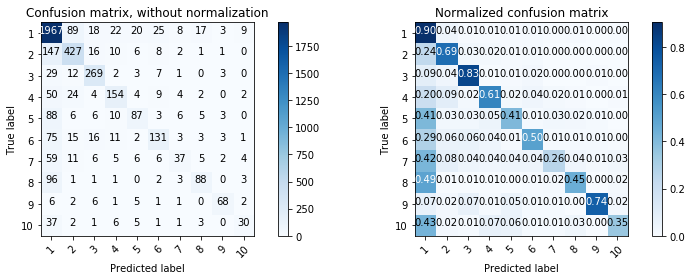

In [35]:
print_confusion_matrix(model = "lr")


## 5. Discussion/Conclusions

The Data that was provided for us is really inbalanced (60% of data is pop/rock) and thus the machine learning predictor is weighted towards pop/rock classes. 

In our solution we first tried to combine principal component analysis( to reduce the features) and logistic regression. However this turned out to reduce too much of the data. After that we changed to Random Forest Classifier which we assumed to predict well, but turned out to be only descent. Our last method, Logistic regression for normalized data gave us best results.

Overall our approach managed to predict quite well against the given imbalanced multiclass dataset. When considering the metrics, it can be said that LogLoss is a much better metric for an imbalanced dataset such as the one in the project. If the training data would have been more balanced, our solution would have given way more accurate results (around 75-90%). However, the test data was so unbalanced, that it was extremely hard to get better than 70% accurate results.

## 6. References

1. http://scikit-learn.org/stable/modules/multiclass.html

2. http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

3. http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

4. http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.transform

5. Course book: https://arxiv.org/abs/1805.05052

6. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4481906/

7. http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

## 7. Appendices

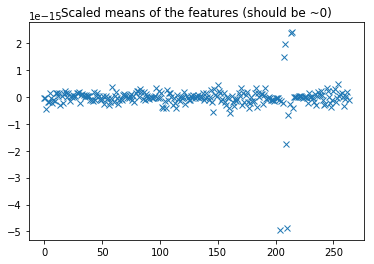

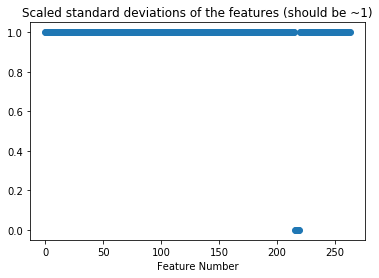

Accuracy for the training data (overfitting): 79.8297 %
Accuracy for the predicted test data: 62.6432 %
Multiclass logarithmic loss for predicted test data: 0.35


In [27]:


# Display data after normalization


mean_scaled_vals = np.zeros((264,1))
dev_scaled_vals = np.zeros((264,1))
for i in range(264):
    mean_scaled_vals[i] = np.mean(all_train_features[:,i])
    dev_scaled_vals[i] = np.std(all_train_features[:,i])
    
plt.plot(mean_scaled_vals,'x')
plt.title("Scaled means of the features (should be ~0)")
plt.show()
plt.plot(dev_scaled_vals,'o')
plt.title("Scaled standard deviations of the features (should be ~1)")
plt.xlabel("Feature Number")
plt.show()


# Performance measure : Accuracy
# we used this to define acuracy for cross validation


y_pred =ovr.predict(features_train)

accuracy_overfit = (np.sum(labels_train[:,0] == y_pred)/labels_train.shape[0])*100
y_pred_test = ovr.predict(features_test)
accu_test  = (np.sum(labels_test[:,0] == y_pred_test)/labels_test.shape[0])*100
print("Accuracy for the training data (overfitting): %.4f" % accuracy_overfit, "%" )

print("Accuracy for the predicted test data: %.4f" % accu_test, "%" )


# Performance measure : LogLoss
# WE used this to define logloss for cross validation


predictProb_test = ovr.predict_proba(features_test)
logilossi = log_loss(labels_test[:,0], predictProb_test, 1e-15)
logilossi = logilossi-1 # 10 different classes, thus
print("Multiclass logarithmic loss for predicted test data: %.2f" % logilossi)


#https://www.kaggle.com/c/predict-closed-questions-on-stack-overflow/discussion/2644

